In [1]:
try:
    import joblib
except ImportError:
    from sklearn.externals import joblib

import os
import json
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from clearml import Task, TaskTypes, Model, OutputModel

/Users/ghassen_benhadjlarbi/miniconda3/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# ClearML Tasks intro
## What is a task in ClearML?
A Task is a single code execution session, which can represent an experiment, a step in a workflow, a workflow controller, or any custom implementation.
To transform an existing script into a ClearML Task, one must call the Task.init() method and specify a task name and its project. This creates a Task object that automatically captures code execution information as well as execution outputs.

## Basic and useful parameters of init method:
+  project_name: project in the WebUI where the task info will be stored. Can create hierarchy of subprojects by using "/" ex: "Project1/subproject1"

+ task_name: name to give the task

+ task_type: One of the enums of TaskTypes, Just changes the icon in the WebUI for easier view of what type of task this is.

+ tags: List of tags to attach to the task. These allow to get more context on the task and tags can be used to filter or query tasks, so it is good practice to give meaningful tags to tasks.

+ reuse_last_task_id: If the task does not generate a model or artifacts, setting this to True will make it so that if the script is ran again, the task will be overwritten. This is useful when trying to debug a training script, but not good for data exploration for example.

+ output_uri: Where to save the models and artifacts produced. Set to True for default ClearML web server, or string for s3/gcs/azure.

+ auto_connect_frameworks: By default, all MatplotLib, XGBoost, scikit-learn, Keras callbacks, and TensorBoard, etc.. are automatically logged.They can be set manually to not be logged or log only specific names. This can be useful for example when having a model checkpoint callback, we don't want to save and upload every single checkpoint. A concrete example of how to use this will be shown later.


# First basic task

## Task init

Based on from https://github.com/allegroai/clearml/blob/master/examples/frameworks/scikit-learn/sklearn_joblib_example.py

In [2]:
task = Task.init(
    project_name="ClearmlStudySessions/tasks_tutorial",
    task_name="first basic task",
    task_type=TaskTypes.training,
    tags=["sklearn", "LogisticRegression", "iris", "baseline"],
    output_uri=True
)

ClearML Task: created new task id=b088f5ebaa334d5eb9ebbe799e6209e9
2023-04-05 08:39:06,285 - clearml.Task - INFO - Storing jupyter notebook directly as code
2023-04-05 08:39:06,333 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: cannot import name 'contextfilter' from 'jinja2' (/Users/ghassen_benhadjlarbi/miniconda3/lib/python3.8/site-packages/jinja2/__init__.py)
ClearML results page: https://app.clear.ml/projects/0b76d6fd1c9e45758eb9da7977e7970e/experiments/b088f5ebaa334d5eb9ebbe799e6209e9/output/log


# Logging and tracking configuration and parameters

ClearML can track Python objects (such as dictionaries and custom classes) and log them to the task’s configuration using the Task.connect method.

In [3]:
params = {"model" : "MobileNetV3",
          "batch_size" : 256,
          "lr" : 1e-4,
          "img_size" : 256}

# The name parameter will correspond to which section in the WebUI we will find the connected parameters. By default, they are saved to the "General" section.
task.connect(mutable=params,
             name="Params")

{'model': 'MobileNetV3', 'batch_size': 256, 'lr': 0.0001, 'img_size': 256}

In [4]:
class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age
        
me = Person("Ghassen", 37)
task.connect(me)

ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


If you change the value of the parameters later in the code, this will not be reflected in the WebUI

In [5]:
params["img_size"] = 224

To update a parameter, use the set_parameter() method. Parameters can be designated into sections: specify a parameter’s section by prefixing its name, delimited with a slash (i.e. section_name/parameter_name:value). General is the default section.

In [6]:
task.set_parameter(name="Params/img_size",value=224)
task.set_parameter(name="age",value=38)

To add or update parameters, use set_parameters_as_dict() method in the same way as set_parameter().

In [7]:
task.set_parameters_as_dict({"Params/dropout": 0.2, "Nationality" : "Tunisian"})

### Accessing parameters

In [8]:
print(task.get_parameters())

{'Params/model': 'MobileNetV3', 'Params/batch_size': '256', 'Params/lr': '0.0001', 'Params/img_size': '224', 'Params/dropout': '0.2', 'General/name': 'Ghassen', 'General/age': '38', 'General/Nationality': 'Tunisian'}


In [9]:
task.get_parameter("Params/model")

'MobileNetV3'

### Configuration objects

To log configuration more elaborate than a key-value dictionary (such as nested dictionaries or configuration files), use the Task.connect_configuration method. This method saves configuration objects as blobs (i.e. ClearML is not aware of their internal structure).

In [10]:
task.connect_configuration(name="yaml conf", 
                           configuration="./data/config.yaml")

'./data/config.yaml'

In [11]:
nested_conf = {'value': 13.37, 
               'dict': {'sub_value': 'string'},  
               'list_of_ints': [1, 2, 3, 4],}
model_config_dict = task.connect_configuration(name="nested_conf", 
                                               configuration=nested_conf)

For better reuse later when cloning tasks, it is better to avoid config objects, or at least flatten them and use connect() to track them.

## Training and saving model

In [12]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model = LogisticRegression(solver='liblinear', multi_class='auto')  # sklearn LogisticRegression class
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [14]:
joblib.dump(model, 'model.pkl', compress=True)

['model.pkl']

## Model evaluation

In [15]:
loaded_model = joblib.load('model.pkl')
result = loaded_model.score(X_test, y_test)

2023-04-05 08:39:34,627 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/ClearmlStudySessions/tasks_tutorial/first%20basic%20task.b088f5ebaa334d5eb9ebbe799e6209e9/models/model.pkl


In [16]:
result

1.0

## Manual Reporting

### Manual logging of score to show it in the "Scalars" tab of the Webui

In [17]:
task.get_logger().report_single_value(name="Score", value=result)

### Automatic logging of matplotlib plots

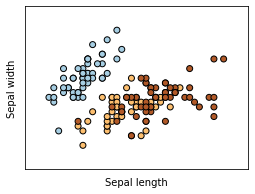

In [18]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.figure(1, figsize=(4, 3))

plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

### Manual logging of images and media (they appear in the "Debug samples" tab of the WebUI)

#### report_media can be used for images, audio and videos (local_path, stream, or url are accepted)

In [19]:
task.get_logger().report_media(
    'video', 'big bunny', iteration=1,
    url='https://test-videos.co.uk/vids/bigbuckbunny/mp4/h264/720/Big_Buck_Bunny_720_10s_1MB.mp4'
)

In [20]:
task.get_logger().report_media(
    'audio', 'pink panther', iteration=1,
    url='https://www2.cs.uic.edu/~i101/SoundFiles/PinkPanther30.wav'
)

In [21]:
task.get_logger().report_media(
    'images', 
    'sample1', 
    iteration=1,
    local_path=os.path.join('data', 'sample1.jpg')
)

In [22]:
task.get_logger().report_image(
    'images', 
    'sample2', 
    iteration=1, 
    local_path=os.path.join('data', 'sample2.jpg')
)

#### report_images is specifically for images (local_path, url or image data)

In [23]:
task.get_logger().report_image(
    'images', 
    'sample3', 
    iteration=1, 
    image=Image.open(os.path.join('data', 'sample3.jpg'))
)

### report_table to report dataframes or tables (use csv, url or table_plot param for df or table as list of rows)

In [24]:
df = pd.read_csv("./data/train.csv")

In [25]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
task.get_logger().report_table(title='table example',
                               series='pandas DataFrame',
                               iteration=0,
                               table_plot=df)

In [27]:
task.get_logger().report_table(title='table example',
                               series='list of rows',
                               iteration=0,
                               table_plot=[["a", "b", "c"], [1,2,3], [4,5,6], [7,8,9]])

## Artifacts

Artifacts are the output files created by a task. ClearML uploads and logs these products, so they can later be easily accessed, modified, and used.
Artifacts can be used to store processed data (best use clearml dataset for that though), or other metadata for your experiment such as performance metrics.

In [28]:
processed_df = df.head()

In [29]:
processed_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Uploading artifacts

In [30]:
task.upload_artifact(name="processed_df", artifact_object=processed_df)

True

In [31]:
task.upload_artifact(name="json_file", artifact_object="./data/sample_json.json")

True

In [32]:
performance = {"train_loss" : 0.01, "train_acc" : 0.95, "val_loss" : 0.04, "val_acc" : 0.91}
task.upload_artifact(name="training_metrics", artifact_object=performance)

True

In [33]:
task.upload_artifact(name="all_data", artifact_object="./data")

True

### Using artifacts

In [34]:
task.artifacts

{'all_data': {'name': 'all_data', 'size': 1234420, 'type': 'archive', 'mode': <ArtifactModeEnum.output: 'output'>, 'url': 'https://files.clear.ml/ClearmlStudySessions/tasks_tutorial/first%20basic%20task.b088f5ebaa334d5eb9ebbe799e6209e9/artifacts/all_data/data.zip', 'hash': '7687376170376616dd8f46abac4ad6f073d0e5a7f59dedf1f848685859ff7554', 'timestamp': datetime.datetime(2023, 4, 5, 8, 39, 42), 'metadata': {}, 'preview': 'Archive content data/*:\nconfig.yaml - 70 bytes\nsample1.jpg - 806.89 KB\nsample2.jpg - 562.88 KB\nsample3.jpg - 247.3 KB\nsample_json.json - 131 bytes\ntrain.csv - 61.19 KB\n'},
 'json_file': {'name': 'json_file', 'size': 131, 'type': 'custom', 'mode': <ArtifactModeEnum.output: 'output'>, 'url': 'https://files.clear.ml/ClearmlStudySessions/tasks_tutorial/first%20basic%20task.b088f5ebaa334d5eb9ebbe799e6209e9/artifacts/json_file/sample_json.json', 'hash': '5c717ef7f88a959f744774b9abe43bfe8a90ad1316692c79a848f00c73f5ddf7', 'timestamp': datetime.datetime(2023, 4, 5, 8, 39

Notice in the url that the dataframe file was compressed to a .csv.gz file!
When downloading it, you will have to unzip it first.
If you upload a folder as an artifact, the folder will also be zipped when uploaded, but unzipped when getting local copy.

In [35]:
task.artifacts["processed_df"]

{'name': 'processed_df', 'size': 377, 'type': 'pandas', 'mode': <ArtifactModeEnum.output: 'output'>, 'url': 'https://files.clear.ml/ClearmlStudySessions/tasks_tutorial/first%20basic%20task.b088f5ebaa334d5eb9ebbe799e6209e9/artifacts/processed_df/processed_df.csv.gz', 'hash': 'd084016a33fa5eba1d276c005c01ada3ed999a3a8879356506477e47a2a05241', 'timestamp': datetime.datetime(2023, 4, 5, 8, 39, 38), 'metadata': {}, 'preview': '   PassengerId  Survived  Pclass  \\\n0            1         0       3   \n1            2         1       1   \n2            3         1       3   \n3            4         1       1   \n4            5         0       3   \n\n                                                Name     Sex   Age  SibSp  \\\n0                            Braund, Mr. Owen Harris    male  22.0      1   \n1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   \n2                             Heikkinen, Miss. Laina  female  26.0      0   \n3       Futrelle, Mrs. Jacques Heath

In [36]:
type(task.artifacts["processed_df"])

clearml.binding.artifacts.Artifact

get_local_copy() will download a local copy of the artifact and return the path to it

In [37]:
processed_df_artifact_local_copy = task.artifacts["processed_df"].get_local_copy()
print(processed_df_artifact_local_copy)

/Users/ghassen_benhadjlarbi/.clearml/cache/storage_manager/global/b1f5824f4168f4d89a16001eafc9c74f.processed_df.csv.gz


get() will download and directly deserialize the artifact

In [38]:
processed_df_artifact = task.artifacts["processed_df"].get()

In [39]:
type(processed_df_artifact)

pandas.core.frame.DataFrame

In [40]:
processed_df_artifact

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [45]:
training_metrics_path = task.artifacts["training_metrics"].get_local_copy()

In [46]:
training_metrics_path

'/Users/ghassen_benhadjlarbi/.clearml/cache/storage_manager/global/9efb9ccba21a974bab5e45552ab3f152.training_metrics.json'

In [47]:
with open(training_metrics_path) as artifact_path:
    training_metrics = artifact_path.read()
print(training_metrics)

{
    "train_acc": 0.95,
    "train_loss": 0.01,
    "val_acc": 0.91,
    "val_loss": 0.04
}


In [48]:
all_data_path = task.artifacts["all_data"].get_local_copy()
print(all_data_path)

/Users/ghassen_benhadjlarbi/.clearml/cache/storage_manager/global/d4e77a4b68f69ea01e3e3a6532906b72.data_artifacts_archive_all_data


In [49]:
os.listdir(all_data_path)

['config.yaml',
 'sample1.jpg',
 'sample3.jpg',
 'sample_json.json',
 'sample2.jpg',
 'train.csv']

Using get() for a folder will just yield a pathlib.Path object to where the folder was downloaded

In [50]:
all_data = task.artifacts["all_data"].get()

In [51]:
all_data

PosixPath('/Users/ghassen_benhadjlarbi/.clearml/cache/storage_manager/global/d4e77a4b68f69ea01e3e3a6532906b72.data_artifacts_archive_all_data')

## Manual configuration of framework logging

You can manually specify which frameworks to automatically log using the "auto_connect_frameworks" parameter of the Task.init() method.
By default, all supported frameworks are automatically logged.
To disable that behavior, you must pass a dictionary where dictionary keys are frameworks names and the values are booleans.
It is also possible to use wildcards to specify specific names of models or artifacts to log and ignore others.

```python
Task.init(
    ...
    auto_connect_frameworks={
    'matplotlib': True, 'tensorflow': ['*.hdf5, '*final_model'], 'tensorboard': True,
    'pytorch': ['*final.pt'], 'xgboost': True, 'scikit': True, 'fastai': True,
    'lightgbm': True, 'hydra': True, 'detect_repository': True, 'tfdefines': True,
    'joblib': True, 'megengine': True, 'catboost': True, 'gradio': True},
    ...
)
```

This is very useful when training a deep learning model with ModelCheckpoint enabled. By default, all model checkpoints will be automatically logged and uploaded, which is probably not the best. Instead, it would be better to disable automatic logging of models and pass a wildcard with the name that you want to save the model at the end, or the name of the intermediary model checkpoints at specific intervals instead.

## Manually log and upload a model

If "auto_connect_frameworks" is set to false for the training framework used, you can still manually log and upload a model.
You need to use the OutputModel class from clearml.

In [52]:
output = OutputModel(task=task, 
                     framework="scikit",
                     tags=["scikit", "baseline", "from_outputmodel"],
                     comment="this is the model manually saved using the outputmodel object.",
                     name="model_from_outputmodel")

You then manually upload the file or folders. This can be done through the Task object or through the OutputModel object.
For Task, use the update_output_model() method.
For OutputModel, use update_weights() for a single file, and update_weights_package() for multiple files or folder.
The next 2 cells will manually upload the same model to the model repository.

In [53]:
task.update_output_model(model_path="./model.pkl",
                         tags=["scikit", "baseline", "from_task"],
                         name="model_from_task",
                         comment="this is the model manually saved using the task object.",
                         model_name="model_from_task",
                         auto_delete_file=False)

'https://files.clear.ml/ClearmlStudySessions/tasks_tutorial/first basic task.b088f5ebaa334d5eb9ebbe799e6209e9/models/model.pkl'

2023-04-05 08:40:37,831 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/ClearmlStudySessions/tasks_tutorial/first%20basic%20task.b088f5ebaa334d5eb9ebbe799e6209e9/models/model.pkl


In [54]:
output.update_weights(weights_filename="model.pkl",
                      target_filename="model_from_outputmodel")

'https://files.clear.ml/ClearmlStudySessions/tasks_tutorial/first basic task.b088f5ebaa334d5eb9ebbe799e6209e9/models/model_from_outputmodel'

2023-04-05 08:40:44,537 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/ClearmlStudySessions/tasks_tutorial/first%20basic%20task.b088f5ebaa334d5eb9ebbe799e6209e9/models/model_from_outputmodel


# Manually close task

In [55]:
# In notebooks, use task.close() to actually complete the task
task.close()